In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from polModel import PolModel
from draine_dust_2D import draine_dust
from model_spec import model_spec

In [2]:
#General plotting function
def pol_plot(mod_p, spec):

    data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    p_measured = data[:,0]
    p_unc = data[:,1]

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    for scat_type in mod_p.keys():
        ax.plot(wave, mod_p[scat_type], 's', label=scat_type)

    ax.legend()
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Model the SDSS Spectrum

In [3]:
spec, model = model_spec()

### Pure Gas Models.

In [4]:
#Define the object
class Gas_Gas(object):
    def get_theta(self, lam_rest):
        return np.ones(len(lam_rest))
    def get_theta_A(self, x, lam_rest):
        return self.get_theta(lam_rest)
    def get_theta_B(self, x, lam_rest):
        return self.get_theta(lam_rest)

In [5]:
#Set the objects
scat_obj = Gas_Gas()
pol_model = PolModel(spec, model)

#Run the fits
x0 = np.array([0.15, 0.15, 45.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([1., 1., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals)
print(pol_model.xopt)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.1129775751895208e-08
       x: [ 1.148e-01  3.204e-01  4.478e+01]
     nit: 15
     jac: [-7.613e-02 -2.179e-04  5.111e-05]
    nfev: 68
    njev: 15


In [6]:
xopt_all = dict()
mod_p_all = dict()
xopt_all["Gas"] = pol_model.xopt
mod_p_all["Gas"] = pol_model.mod_p

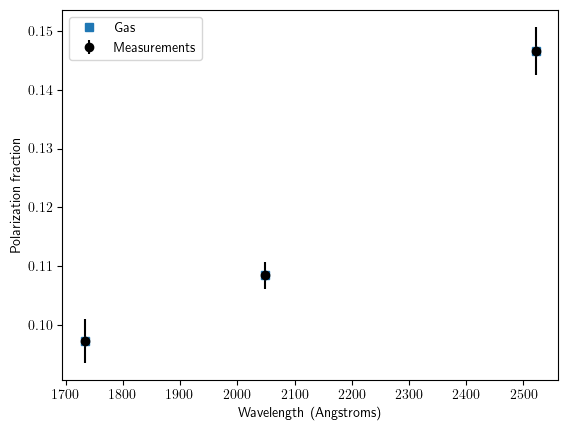

In [7]:
pol_plot(mod_p_all, spec)

### Pure Dust Models.

In [8]:
#Define the object.
class Dust_Dust(object):

    def __init__(self, dust_type):
        #Load the dust model. 
        self.dust = draine_dust(dust_type)
        return

    def get_theta(self, x, lam_rest):
        phi = x[3]
        return self.dust.pfrac(lam_rest.to(u.um).value, phi).flatten()
    
    def get_theta_A(self, x, lam_rest):
        return self.get_theta(x, lam_rest)
    
    def get_theta_B(self, x, lam_rest):
        return self.get_theta(x, lam_rest)



In [9]:
dust_types = ["SMC", "LMC", "MW"]

In [10]:
for dust_type in dust_types:
    #Set the objects
    scat_obj = Dust_Dust(dust_type)

    #Run the fits. Attempt a start with scattering angle < 90. and > 90.
    x0 = np.array([0.9, 0.3, 70., 90.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([1., 1., 90., 180.])
    for i in range(2):
        if i==0:
            x0[-1] = 60.
        else:
            x0[-1] = 170.
        pol_model_aux = PolModel(spec, model)
        pol_model_aux.fit_pol(scat_obj, x0, min_vals, max_vals)
        if i==0 or pol_model_aux.xopt.fun < pol_model.xopt.fun:
            pol_model = pol_model_aux

    print(pol_model.xopt)

    #Save the results.
    xopt_all["DD_"+dust_type] = pol_model.xopt
    mod_p_all["DD_"+dust_type] = pol_model.mod_p



 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.512303737907138e-09
       x: [ 8.791e-01  9.935e-01  7.558e+01  7.864e+01]
     nit: 18
     jac: [-6.930e-02  2.376e-02  2.007e-03 -3.696e-04]
    nfev: 98
    njev: 18
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 164.85736854477204
       x: [ 1.000e+00  6.947e-01  9.000e+01  6.331e+01]
     nit: 21
     jac: [-5.319e+02 -8.535e-03 -9.537e-06 -1.507e-04]
    nfev: 111
    njev: 20
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.026318985723632e-08
       x: [ 9.608e-01  6.193e-01  7.782e+01  6.155e+01]
     nit: 19
     jac: [-2.692e-02  5.003e-03  7.786e-05 -1.190e-04]
    nfev: 102
    njev: 19


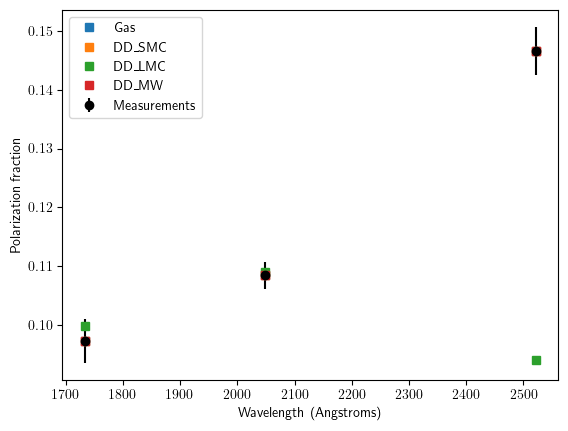

In [11]:
pol_plot(mod_p_all, spec)

### Dust for continuum, Gas for emission lines.

In [12]:
class Dust_Gas(Dust_Dust):

    def __init__(self, dust_type):
        #Load the dust model. 
        self.dust = draine_dust(dust_type)
        return

    def get_theta_A(self, x, lam_rest):
        phi = x[3]
        return self.dust.pfrac(lam_rest.to(u.um).value, phi).flatten()
    
    def get_theta_B(self, x, lam_rest):
        return np.ones(len(spec.lam_rest))

In [13]:
for dust_type in dust_types:
    #Set the objects
    scat_obj = Dust_Gas(dust_type)

    #Run the fits. Attempt a start with scattering angle < 90. and > 90.
    x0 = np.array([0.9, 0.5, 70., 90.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([1., 1., 90., 180.])
    for i in range(2):
        if i==0:
            x0[-1] = 60.
        else:
            x0[-1] = 170.
        pol_model_aux = PolModel(spec, model)
        pol_model_aux.fit_pol(scat_obj, x0, min_vals, max_vals)
        if i==0 or pol_model_aux.xopt.fun < pol_model.xopt.fun:
            pol_model = pol_model_aux

    print(pol_model.xopt)

    #Save the results.
    xopt_all["DG_"+dust_type] = pol_model.xopt
    mod_p_all["DG_"+dust_type] = pol_model.mod_p



 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.20736036360571
       x: [ 1.000e+00  4.304e-01  9.000e+01  1.075e+02]
     nit: 74
     jac: [-1.523e+01  6.286e-03 -1.514e-05  5.332e-04]
    nfev: 398
    njev: 74
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 152.3509681138094
       x: [ 1.000e+00  1.088e-01  9.000e+01  1.276e+02]
     nit: 27
     jac: [-4.865e+02 -9.190e-03 -1.526e-05 -1.564e-04]
    nfev: 152
    njev: 27
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 11.251755404159852
       x: [ 1.000e+00  7.596e-02  8.994e+01  5.289e+01]
     nit: 71
     jac: [-7.682e+00 -4.918e-02 -8.345e-06  6.317e-04]
    nfev: 378
    njev: 71


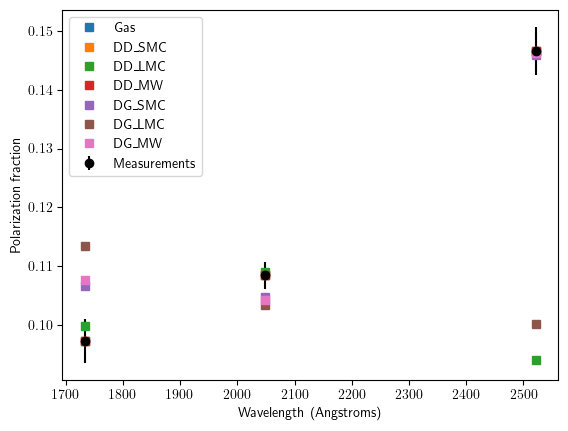

In [14]:
pol_plot(mod_p_all, spec)